# 📰 Fake News Detection with Neural Networks
This project classifies news articles as fake or real using a neural network trained on labeled text data.

## 📘 Step 1: Train the Neural Network

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aryanshelke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aryanshelke/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# Load the LIAR dataset
df = pd.read_csv('../datasets/liar/train.tsv', sep='\t', header=None)
df.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context']

# Map labels to binary classification
label_map = {
    'true': 1,
    'mostly-true': 1,
    'half-true': 1,
    'barely-true': 0,
    'false': 0,
    'pants-fire': 0
}
df['label'] = df['label'].map(label_map)

# Keep only the statement and label columns
df = df[['statement', 'label']]
print("Dataset shape:", df.shape)

Dataset shape: (10240, 2)


In [8]:
# Text preprocessing function
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize and remove stopwords
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return ' '.join(words)

# Apply preprocessing to statement column
df['statement'] = df['statement'].apply(preprocess_text)

# Tokenization parameters
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 200

# Initialize tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(df['statement'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['statement'])

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['label'], 
                                                    test_size=0.2, random_state=42)

# Print shapes to verify
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (8192, 200)
Testing data shape: (2048, 200)


Epoch 1/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.5397 - loss: 0.6897 - val_accuracy: 0.5790 - val_loss: 0.6815
Epoch 2/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.5623 - loss: 0.6858 - val_accuracy: 0.5790 - val_loss: 0.6817
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.5551 - loss: 0.6886 - val_accuracy: 0.5790 - val_loss: 0.6829
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5574 - loss: 0.6868

Test Accuracy: 0.5664
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       888
           1       0.57      1.00      0.72      1160

    accuracy                           0.57      2048
   macro avg       0.28      0.50      0.36      2048
weighted avg       0.32      0.57      0.41      2048

Confusion Matrix:

[[   0  888]
 [   0 1160]]


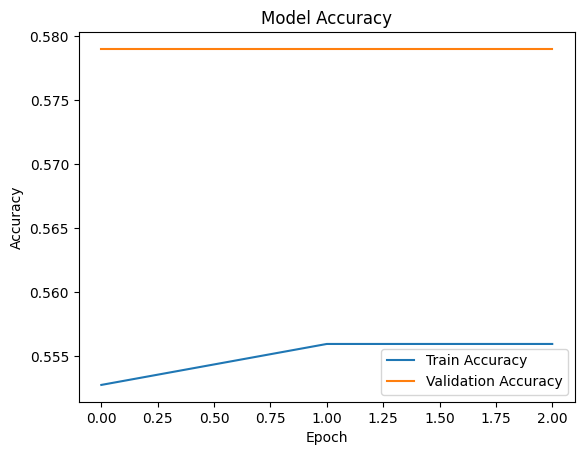

In [9]:
# Build the Model
model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,)))
model.add(Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=64))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the Model
es = EarlyStopping(monitor='val_loss', patience=2)
history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.2, callbacks=[es])

# Evaluate the Model
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc:.4f}")

y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))
print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [10]:
# Save the model
with open('../models/Liar/LSTM_Liar_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the tokenizer
with open('../models/Liar/LSTM_Liar_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)